# Development

All code here is experimental. Please see README for current usage instructions.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from forecastiso.data_loader import ISODataLoader
from forecastiso.features import (
    FeatureManager,
    LagFeatureGenerator,
    RollingFeatureGenerator,
    CalendarFeatureGenerator,
    InteractionFeatureGenerator,
)
from forecastiso.forecasters import LinearRegressionForecaster, GradientBoostingForecaster

# plt.style.use("seaborn-v0_8-paper")
# plt.style.use("bmh")

In [2]:
df = pd.read_pickle("../data/caiso_hourly/preprocessed_hourly_load.pkl")
df.head()

,datetime,area,load
0,2022-01-01 00:00:00,caiso,22303.67
1,2022-01-01 01:00:00,caiso,21491.08
2,2022-01-01 02:00:00,caiso,21041.72
3,2022-01-01 03:00:00,caiso,20875.96
4,2022-01-01 04:00:00,caiso,20901.42


In [3]:
# limit to one area
df = df[df["area"] == "caiso"]
df = df.drop(columns=["area"])

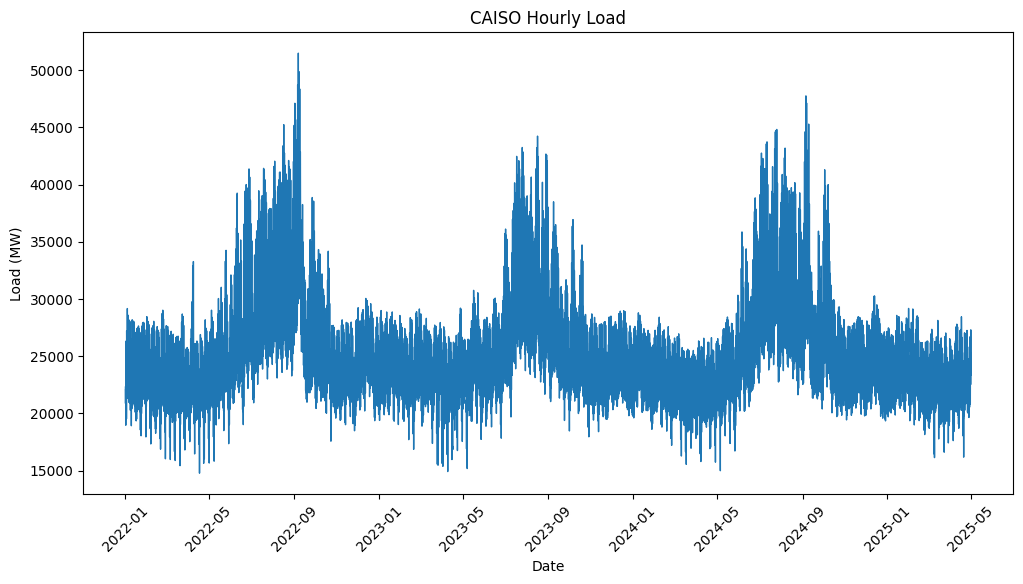

In [4]:
# line plot
plt.figure(figsize=(12, 6))
plt.plot(df["datetime"], df["load"], label="Load", linewidth=1)
plt.title("CAISO Hourly Load")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.xticks(rotation=45)
plt.show()

In [21]:
# filter for a specific date range
start_date = "2022-01-01"
predict_date = "2025-02-04"
df_filtered = df[(df["datetime"] >= start_date) & (df["datetime"] < predict_date)]

ground_truth = df[df["datetime"].dt.strftime("%Y-%m-%d") == predict_date]["load"].reset_index(drop=True)

In [22]:
# generate features

fm = FeatureManager()
fm.add_generator(LagFeatureGenerator(lags=[24, 48, 168]))
fm.add_generator(RollingFeatureGenerator(windows=[24, 168, 720]))
fm.add_generator(CalendarFeatureGenerator())
fm.add_generator(InteractionFeatureGenerator([["hour", "is_weekend"]]))
features_df = fm.generate_features(df_filtered)

print(features_df.shape)
print(features_df.columns)
print(features_df.dtypes)

(26952, 28)
Index(['load', 'load_lag_24', 'load_lag_48', 'load_lag_168',
       'load_rolling_mean_24', 'load_rolling_std_24', 'load_rolling_min_24',
       'load_rolling_max_24', 'load_rolling_mean_168', 'load_rolling_std_168',
       'load_rolling_min_168', 'load_rolling_max_168', 'load_rolling_mean_720',
       'load_rolling_std_720', 'load_rolling_min_720', 'load_rolling_max_720',
       'hour', 'dayofweek', 'month', 'day', 'quarter', 'year', 'dayofyear',
       'is_weekend', 'is_holiday', 'day_before_holiday', 'day_after_holiday',
       'hour_is_weekend'],
      dtype='object')
load                     float64
load_lag_24              float64
load_lag_48              float64
load_lag_168             float64
load_rolling_mean_24     float64
load_rolling_std_24      float64
load_rolling_min_24      float64
load_rolling_max_24      float64
load_rolling_mean_168    float64
load_rolling_std_168     float64
load_rolling_min_168     float64
load_rolling_max_168     float64
load_rolling_

In [23]:
forecaster = LinearRegressionForecaster(
    feature_cols=["load_lag_24", "load_lag_48", "load_lag_168",
                  "load_rolling_mean_24", "load_rolling_mean_168", "load_rolling_mean_720",
                  "hour", "month", "dayofweek", "is_weekend", "day", "quarter", "hour_is_weekend"],
    target_col="load",
    # use_ridge=True,
    # alpha=1.0,
)

forecaster.fit(features_df)

prediction = forecaster.predict(horizon=24)


['is_weekend']
['load_lag_24', 'load_lag_48', 'load_lag_168', 'load_rolling_mean_24', 'load_rolling_mean_168', 'load_rolling_mean_720', 'hour', 'month', 'dayofweek', 'day', 'quarter', 'hour_is_weekend']


In [24]:
prediction

0     20577.456881
1     22243.058260
2     28703.070086
3     43916.321370
4     51247.675317
5     35165.970081
6     18733.181958
7      7563.197608
8      5864.193661
9      7607.711438
10    11574.001586
11    17604.498068
12    24661.645772
13    37308.506526
14    58688.294310
15    62886.341878
16    46568.198610
17    54752.027753
18    61295.868539
19    56147.581618
20    34525.737234
21    25682.124122
22    29752.891119
23    24165.627517
dtype: float64

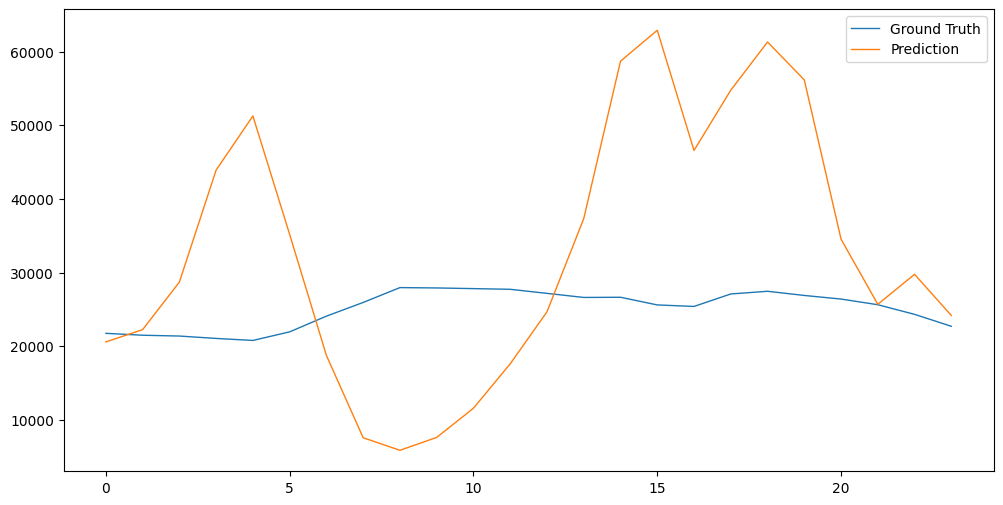

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(ground_truth, label="Ground Truth", linewidth=1)
plt.plot(prediction, label="Prediction", linewidth=1)
plt.legend()
plt.show()

In [33]:
forecaster = GradientBoostingForecaster(
    feature_cols=["load_lag_24", "load_lag_48", "load_lag_168",
                 "load_rolling_mean_24", "load_rolling_min_24", "load_rolling_max_24", "load_rolling_std_24",
                 "load_rolling_mean_168", "load_rolling_min_168", "load_rolling_max_168", "load_rolling_std_168",
                 "load_rolling_mean_720", "load_rolling_min_720", "load_rolling_max_720", "load_rolling_std_720",
                 "hour", "month", "dayofweek", "is_holiday", "day_before_holiday", "is_weekend", "day", "quarter", "hour_is_weekend"],
    target_col="load",
)

forecaster.fit(features_df)
prediction = forecaster.predict(horizon=24)

In [34]:
prediction

0     21654.638672
1     21297.666016
2     21190.019531
3     22046.783203
4     23811.986328
5     25044.437500
6     26399.398438
7     26640.832031
8     26391.783203
9     25880.681641
10    25896.550781
11    25391.359375
12    24584.175781
13    24500.736328
14    24063.218750
15    25307.515625
16    27174.833984
17    28488.876953
18    28126.603516
19    27341.191406
20    26491.929688
21    25099.859375
22    23640.923828
23    22672.273438
dtype: float32

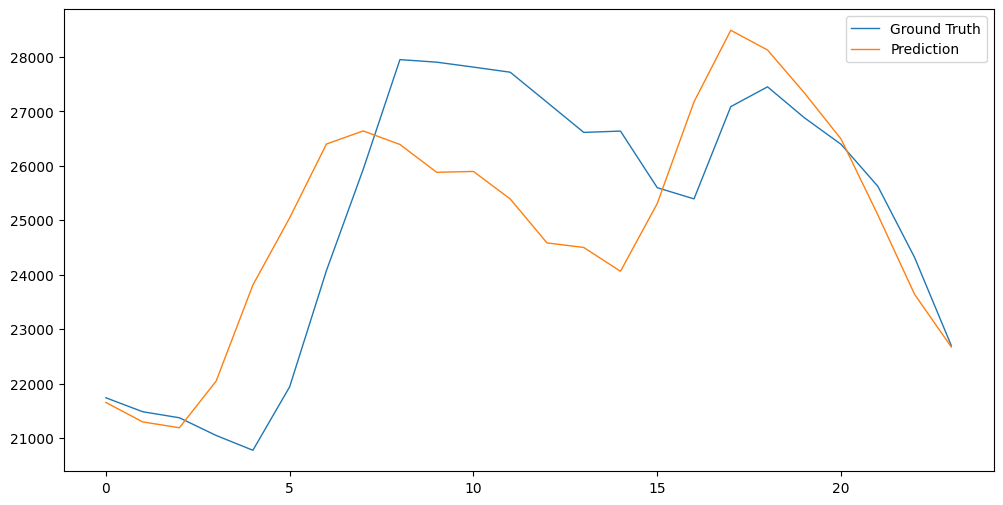

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(ground_truth, label="Ground Truth", linewidth=1)
plt.plot(prediction, label="Prediction", linewidth=1)
plt.legend()
plt.show()